In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys() 

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(most_recent_date)

2017-08-23


C:\Users\arkha\AppData\Local\Temp\ipykernel_23476\2497371706.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
C:\Users\arkha\AppData\Local\Temp\ipykernel_23476\2497371706.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.sort_values(by = 'Date', inplace = True)


<function matplotlib.pyplot.show(close=None, block=None)>

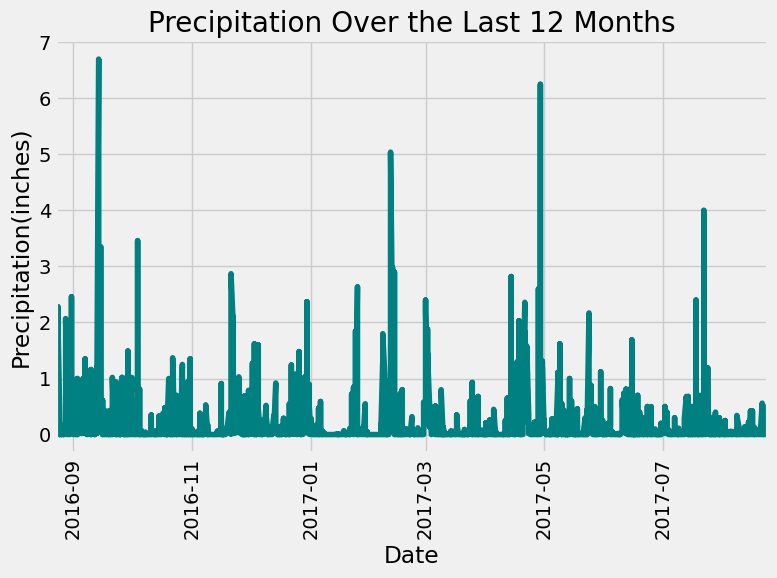

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
twelve_months_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(twelve_months_data, columns = ['Date', 'Precipitation'])

# Check for missing values (NaN) in the Precipitation column
missing_values = df['Precipitation'].isnull().sum()

# Convert the 'Date' column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

df_cleaned = df.dropna(subset=['Precipitation'])

# Convert the 'Date' column to datetime (if not already in datetime format)
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

#Sort the dataframe by date
df_cleaned.sort_values(by = 'Date', inplace = True)


#Use Pandas Plotting with Matplotlib to plot the data

start_date = pd.Timestamp('2016-08-23')  # Start date
end_date = pd.Timestamp('2017-08-24')    # End date



plt.figure(figsize = (8, 6))
plt.plot(df_cleaned['Date'], df_cleaned['Precipitation'], label = 'Precipitaion', color = 'teal')
plt.xlim(start_date, end_date)
plt.xlabel('Date')
plt.ylabel('Precipitation(inches)')
plt.title('Precipitation Over the Last 12 Months')
plt.xticks(rotation = 90)
plt.grid(True) 
plt.tight_layout()
plt.show



In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Drop the 'Date' column and then calculate summary statistics for the remaining columns
summary_stats = df_cleaned.drop(columns=['Date']).describe()

# Print the result 
summary_stats


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.station).count()
print(station_count)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = session.query(
        Measurement.station,
        func.count(Measurement.tobs)
).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())

# Execute the query and fetch the result
result_activity = query.all()

#Print the results
for station, count in result_activity:
    print(station, count)



USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query_temps = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == 'USC00519281')

#execute query and fetch the result
result = query_temps.one()

#Print the results
min_temp, max_temp, avg_temp = result
print(f'Station: USC00519281')
print(f'Lowest Temperature: {min_temp}')
print(f'Highest Temperature: {max_temp}')
print(f'Average Temperature: {avg_temp}')

Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


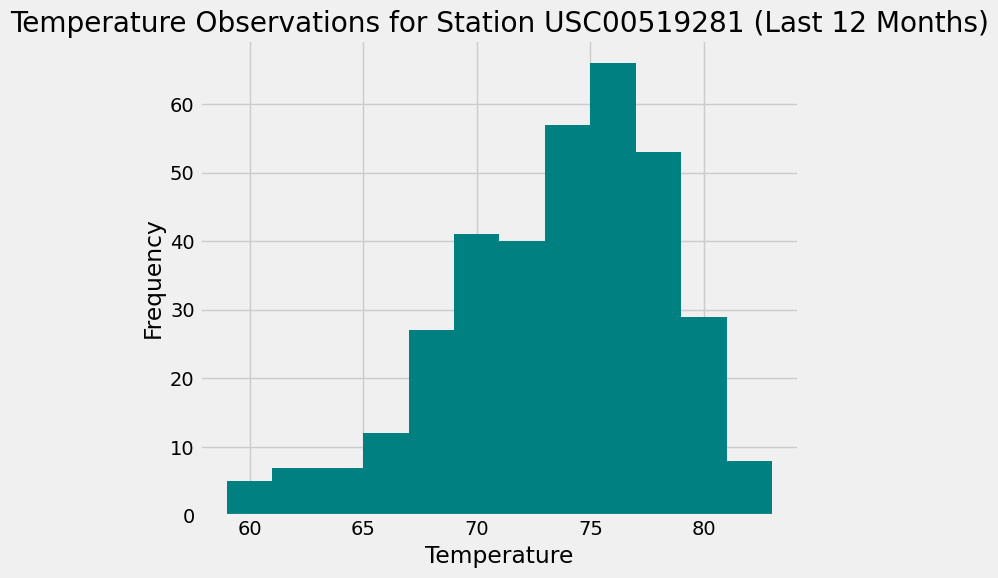

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
id = 'USC00519281'
recent_date = dt.datetime(2017, 8, 23)

# Calculate the date 12 months ago from the most recent date
start_date = recent_date - dt.timedelta(days=365)

# Query to find the last 12 months of 'tobs' for the station 'USC00519281'
query = session.query(Measurement.tobs).filter(
    Measurement.station == id,
    Measurement.date >= start_date.strftime('%Y-%m-%d')  
)

results = query.all()

# Extract tobs values
tobs_values = [tobs[0] for tobs in results] 

# Plot the results as a histogram
plt.figure(figsize=(7, 6))
plt.hist(tobs_values, bins = 12, color='teal')
plt.title(f'Temperature Observations for Station {id} (Last 12 Months)')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()